In [1]:
# Step 1: Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
# Step 2: Upload dataset
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
df['location'] = 'Maharashtra'
df['date'] = pd.to_datetime(df['date'])

Saving long_term_weather_2000_2025.csv to long_term_weather_2000_2025.csv


In [3]:
# Step 3: Add season feature
df['month'] = df['date'].dt.month
def month_to_season(month):
    if month in [6,7,8,9]:   # Monsoon
        return 2
    elif month in [3,4,5]:   # Summer
        return 1
    else:                     # Winter/Other
        return 0
df['season'] = df['month'].apply(month_to_season)

print("✅ Dataset with season feature:")
print(df.head())

✅ Dataset with season feature:
        date  temperature  humidity  rainfall     location  month  season
0 2000-01-01        25.50     61.45      0.33  Maharashtra      1       0
1 2000-01-02        24.94     60.33      0.02  Maharashtra      1       0
2 2000-01-03        25.81     63.73      0.40  Maharashtra      1       0
3 2000-01-04        26.77     60.06      0.22  Maharashtra      1       0
4 2000-01-05        25.10     63.44      0.55  Maharashtra      1       0


In [4]:
# Step 4: Keep numeric columns for model
features = ['temperature', 'humidity', 'rainfall', 'season']
df_model = df[features].dropna()
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_model)

In [5]:
# Step 5: Prepare sequences
time_steps = 10
def make_sequences(data, step=time_steps):
    X, y = [], []
    for i in range(len(data)-step):
        X.append(data[i:i+step])
        y.append(data[i+step,[0,2]])  # Predict temp & rainfall
    return np.array(X), np.array(y)

X, y = make_sequences(scaled, time_steps)

In [6]:
# Step 6: Split train/test
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(f"\n✅ Training samples: {len(X_train)}, Testing samples: {len(X_test)}")


✅ Training samples: 7589, Testing samples: 1898


In [7]:
# Step 7: Build LSTM with Monte Carlo Dropout
def build_mc_lstm():
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(time_steps, X.shape[2])),
        Dropout(0.3),  # MC Dropout
        LSTM(32),
        Dropout(0.3),
        Dense(2)  # temp & rainfall
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_mc_lstm()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,146 (117.76 KB)

 Trainable params: 30,146 (117.76 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Step 8: Train model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

Epoch 1/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0742
Epoch 2/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0123
Epoch 3/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0114
Epoch 4/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0104
Epoch 5/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0094
Epoch 6/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0093
Epoch 7/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0086
Epoch 8/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0082
Epoch 9/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0079
Epoch 10/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0074
Epoch 11/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0072
Epoch 12/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0070
Epoch 13/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0071
Epoch 14/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0070
Epoch 15/25
238/238 ━━━━━━━━━━━━━━━━━━━━ 4s

In [9]:
# Step 9: Monte Carlo prediction function
def mc_predict(model, x_input, T=50):
    preds = []
    for _ in range(T):
        pred = model(x_input, training=True).numpy()
        preds.append(pred)
    return np.array(preds)

In [10]:
# Step 10: Predict on test data
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
mc_preds = mc_predict(model, X_test_tf, T=50)
mc_mean = mc_preds.mean(axis=0)
mc_std = mc_preds.std(axis=0)

# Inverse transform
dummy = np.zeros((len(mc_mean), scaled.shape[1]))
dummy[:, [0,2]] = mc_mean
pred_inv = scaler.inverse_transform(dummy)[:, [0,2]]

dummy_true = np.zeros((len(y_test), scaled.shape[1]))
dummy_true[:, [0,2]] = y_test
y_true_inv = scaler.inverse_transform(dummy_true)[:, [0,2]]

In [11]:
# Step 11: Evaluate
temp_rmse = np.sqrt(mean_squared_error(y_true_inv[:,0], pred_inv[:,0]))
rain_rmse = np.sqrt(mean_squared_error(y_true_inv[:,1], pred_inv[:,1]))
print(f"\n📊 Model Performance for Maharashtra:")
print(f"Temperature RMSE: {temp_rmse:.2f}")
print(f"Rainfall RMSE: {rain_rmse:.2f}")


📊 Model Performance for Maharashtra:
Temperature RMSE: 1.16
Rainfall RMSE: 1.04


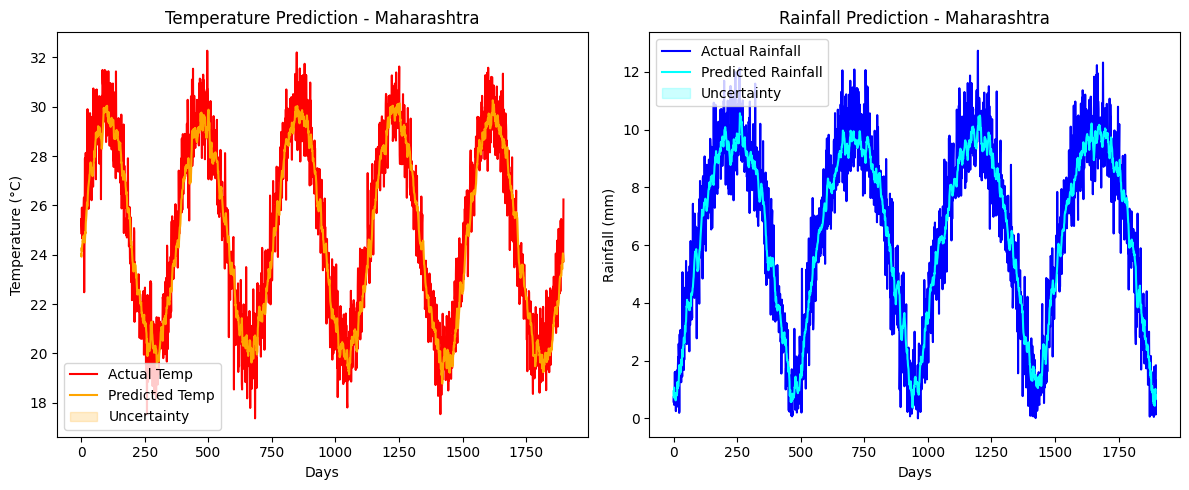

In [12]:
# Step 12: Plot test results with uncertainty
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(y_true_inv[:,0], label='Actual Temp', color='red')
plt.plot(pred_inv[:,0], label='Predicted Temp', color='orange')
plt.fill_between(range(len(pred_inv[:,0])),
                 pred_inv[:,0]-mc_std[:,0],
                 pred_inv[:,0]+mc_std[:,0],
                 color='orange', alpha=0.2, label='Uncertainty')
plt.title("Temperature Prediction - Maharashtra")
plt.xlabel("Days")
plt.ylabel("Temperature (°C)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(y_true_inv[:,1], label='Actual Rainfall', color='blue')
plt.plot(pred_inv[:,1], label='Predicted Rainfall', color='cyan')
plt.fill_between(range(len(pred_inv[:,1])),
                 pred_inv[:,1]-mc_std[:,1],
                 pred_inv[:,1]+mc_std[:,1],
                 color='cyan', alpha=0.2, label='Uncertainty')
plt.title("Rainfall Prediction - Maharashtra")
plt.xlabel("Days")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Step 13: Forecast next 7 days probabilistically with season
last_seq = X_test[-1].reshape(1, time_steps, X.shape[2])
future_preds = []

for _ in range(7):
    seq_tf = tf.convert_to_tensor(last_seq, dtype=tf.float32)
    pred_mc = mc_predict(model, seq_tf, T=50)
    pred_mean = pred_mc.mean(axis=0)[0]
    pred_std = pred_mc.std(axis=0)[0]
    future_preds.append((pred_mean, pred_std))

    # Dynamic humidity simulation
    predicted_temp = pred_mean[0]
    predicted_rain = pred_mean[1]
    predicted_humidity = np.clip(np.random.uniform(0.4, 0.8), 0, 1)

    # Keep season same as last day
    predicted_season = last_seq[0,-1,3]
    new_row = np.array([predicted_temp, predicted_humidity, predicted_rain, predicted_season]).reshape(1,1,4)
    last_seq = np.concatenate((last_seq[:,1:,:], new_row), axis=1)

In [14]:
# Step 14: Inverse transform future predictions
future_mean = np.array([x[0] for x in future_preds])
future_std = np.array([x[1] for x in future_preds])

dummy_future = np.zeros((len(future_mean), scaled.shape[1]))
dummy_future[:, [0,2]] = future_mean
future_inv = scaler.inverse_transform(dummy_future)[:, [0,2]]

# Add uncertainty
temp_upper = future_inv[:,0] + future_std[:,0]
temp_lower = future_inv[:,0] - future_std[:,0]
rain_upper = future_inv[:,1] + future_std[:,1]
rain_lower = np.clip(future_inv[:,1] - future_std[:,1], 0, None)

In [15]:
# Step 15: Display forecast
print("\n🌦 Probabilistic 7-Day Forecast for Maharashtra (Season-Aware):")
for i in range(7):
    print(f"Day {i+1} (Maharashtra):")
    print(f"  Temperature: {temp_lower[i]:.2f}°C - {temp_upper[i]:.2f}°C")
    print(f"  Rainfall: {rain_lower[i]:.2f} mm - {rain_upper[i]:.2f} mm")


🌦 Probabilistic 7-Day Forecast for Maharashtra (Season-Aware):
Day 1 (Maharashtra):
  Temperature: 23.85°C - 23.92°C
  Rainfall: 0.81 mm - 0.94 mm
Day 2 (Maharashtra):
  Temperature: 23.71°C - 23.79°C
  Rainfall: 0.71 mm - 0.85 mm
Day 3 (Maharashtra):
  Temperature: 23.63°C - 23.69°C
  Rainfall: 0.83 mm - 0.95 mm
Day 4 (Maharashtra):
  Temperature: 23.58°C - 23.65°C
  Rainfall: 0.93 mm - 1.05 mm
Day 5 (Maharashtra):
  Temperature: 23.36°C - 23.44°C
  Rainfall: 1.01 mm - 1.11 mm
Day 6 (Maharashtra):
  Temperature: 23.26°C - 23.34°C
  Rainfall: 1.16 mm - 1.25 mm
Day 7 (Maharashtra):
  Temperature: 23.04°C - 23.11°C
  Rainfall: 0.98 mm - 1.12 mm


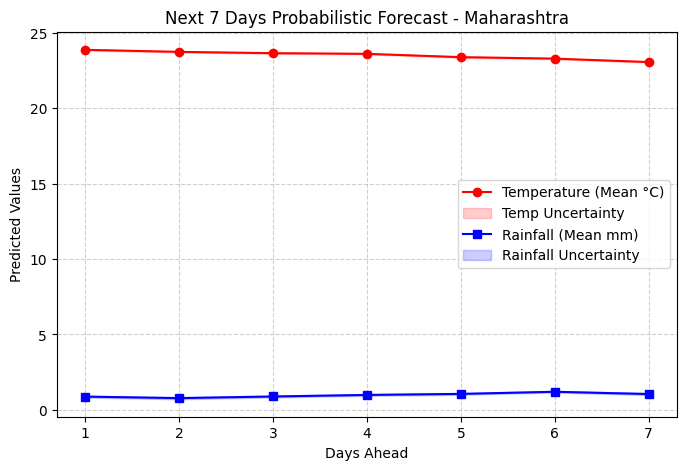

In [16]:
# Step 16: Plot forecast
plt.figure(figsize=(8,5))
days = range(1,8)
plt.plot(days, future_inv[:,0], 'o-r', label='Temperature (Mean °C)')
plt.fill_between(days, temp_lower, temp_upper, color='red', alpha=0.2, label='Temp Uncertainty')
plt.plot(days, future_inv[:,1], 's-b', label='Rainfall (Mean mm)')
plt.fill_between(days, rain_lower, rain_upper, color='blue', alpha=0.2, label='Rainfall Uncertainty')
plt.title("Next 7 Days Probabilistic Forecast - Maharashtra")
plt.xlabel("Days Ahead")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()